# Item Data Cleaning (for Judge)

本笔记本基于现有 item 字段生成清洗版数据，便于后续 judge（评测/判别）。

**输入**: `data/industrial_and_scientific_items.csv`
**输出**: `data/industrial_and_scientific_items_clean.csv`


## 清洗原则
- 去重：以 `parent_asin` 为唯一键
- 必要字段：`parent_asin`, `title`, `main_category`, `categories`, `price`, `average_rating`, `rating_number`, `store`, `features`, `description`
- 删除字段：`images`, `videos`, `bought_together`, `subtitle`, `author`, `details`
- 数值规范化：`price`, `average_rating`, `rating_number`
- 文本清洗：去多余空白；可按需截断


In [2]:
import csv
import re
from pathlib import Path

base_dir = Path('.')
src = base_dir / 'data' / 'industrial_and_scientific_items.csv'
dst = base_dir / 'data' / 'industrial_and_scientific_items_clean.csv'

def to_float(x):
    if x is None:
        return ''
    x = x.strip()
    if not x:
        return ''
    x = re.sub(r'[^0-9.]', '', x)
    try:
        return str(float(x))
    except Exception:
        return ''

def to_int(x):
    if x is None:
        return ''
    x = x.strip()
    if not x:
        return ''
    x = re.sub(r'[^0-9]', '', x)
    try:
        return str(int(x))
    except Exception:
        return ''

keep_cols = [
    'parent_asin', 'title', 'main_category', 'categories', 'price',
    'average_rating', 'rating_number', 'store', 'features', 'description'
]

seen = {}

with open(src, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        title = (row.get('title') or '').strip()
        if not title:
            continue
        key = (row.get('parent_asin') or '').strip()
        if not key:
            continue

        row['price'] = to_float(row.get('price'))
        row['average_rating'] = to_float(row.get('average_rating'))
        row['rating_number'] = to_int(row.get('rating_number'))
        row['main_category'] = (row.get('main_category') or 'Unknown').strip()

        # 去重策略：保留信息更完整的记录
        score = 0
        for col in ['title', 'price', 'average_rating', 'features', 'description']:
            if (row.get(col) or '').strip():
                score += 1
        if key not in seen or score > seen[key][0]:
            seen[key] = (score, row)

with open(dst, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=keep_cols)
    writer.writeheader()
    for _, row in seen.values():
        out = {k: (row.get(k) or '').strip() for k in keep_cols}
        writer.writerow(out)

print('cleaned items:', len(seen))
print('output ->', dst)


cleaned items: 427539
output -> data/industrial_and_scientific_items_clean.csv


In [3]:
import csv

total = 0
empty_counts = {k: 0 for k in keep_cols}

with open(dst, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        total += 1
        for k in keep_cols:
            v = (row.get(k) or '').strip()
            if not v:
                empty_counts[k] += 1

print('total rows:', total)
for k in keep_cols:
    cnt = empty_counts[k]
    ratio = (cnt / total) if total else 0
    print(f"{k}: empty={cnt}, ratio={ratio:.2%}")


total rows: 427539
parent_asin: empty=0, ratio=0.00%
title: empty=0, ratio=0.00%
main_category: empty=0, ratio=0.00%
categories: empty=0, ratio=0.00%
price: empty=204602, ratio=47.86%
average_rating: empty=0, ratio=0.00%
rating_number: empty=0, ratio=0.00%
store: empty=3452, ratio=0.81%
features: empty=0, ratio=0.00%
description: empty=0, ratio=0.00%


In [4]:
import csv

text_cols = ['title', 'main_category', 'categories', 'store', 'features', 'description']
lengths = {k: [] for k in text_cols}

with open(dst, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        for k in text_cols:
            v = (row.get(k) or '').strip()
            lengths[k].append(len(v))

def summarize(arr):
    if not arr:
        return {'min': 0, 'p25': 0, 'p50': 0, 'p75': 0, 'p90': 0, 'p95': 0, 'max': 0, 'mean': 0}
    a = sorted(arr)
    n = len(a)
    def pct(p):
        if n == 1:
            return a[0]
        idx = int(round(p * (n - 1)))
        return a[idx]
    mean = sum(a) / n
    return {
        'min': a[0],
        'p25': pct(0.25),
        'p50': pct(0.50),
        'p75': pct(0.75),
        'p90': pct(0.90),
        'p95': pct(0.95),
        'max': a[-1],
        'mean': round(mean, 2),
    }

for k in text_cols:
    stats = summarize(lengths[k])
    print(k, stats)


title {'min': 1, 'p25': 67, 'p50': 95, 'p75': 138, 'p90': 176, 'p95': 191, 'max': 1254, 'mean': 103.5}
main_category {'min': 4, 'p25': 23, 'p50': 23, 'p75': 23, 'p90': 24, 'p95': 24, 'max': 28, 'mean': 20.8}
categories {'min': 2, 'p25': 73, 'p50': 96, 'p75': 113, 'p90': 124, 'p95': 136, 'max': 163, 'mean': 89.22}
store {'min': 0, 'p25': 6, 'p50': 8, 'p75': 12, 'p90': 17, 'p95': 20, 'max': 289, 'mean': 9.71}
features {'min': 2, 'p25': 55, 'p50': 235, 'p75': 530, 'p90': 1014, 'p95': 1271, 'max': 7717, 'mean': 376.36}
description {'min': 2, 'p25': 2, 'p50': 179, 'p75': 571, 'p90': 1130, 'p95': 1563, 'max': 20701, 'mean': 391.88}


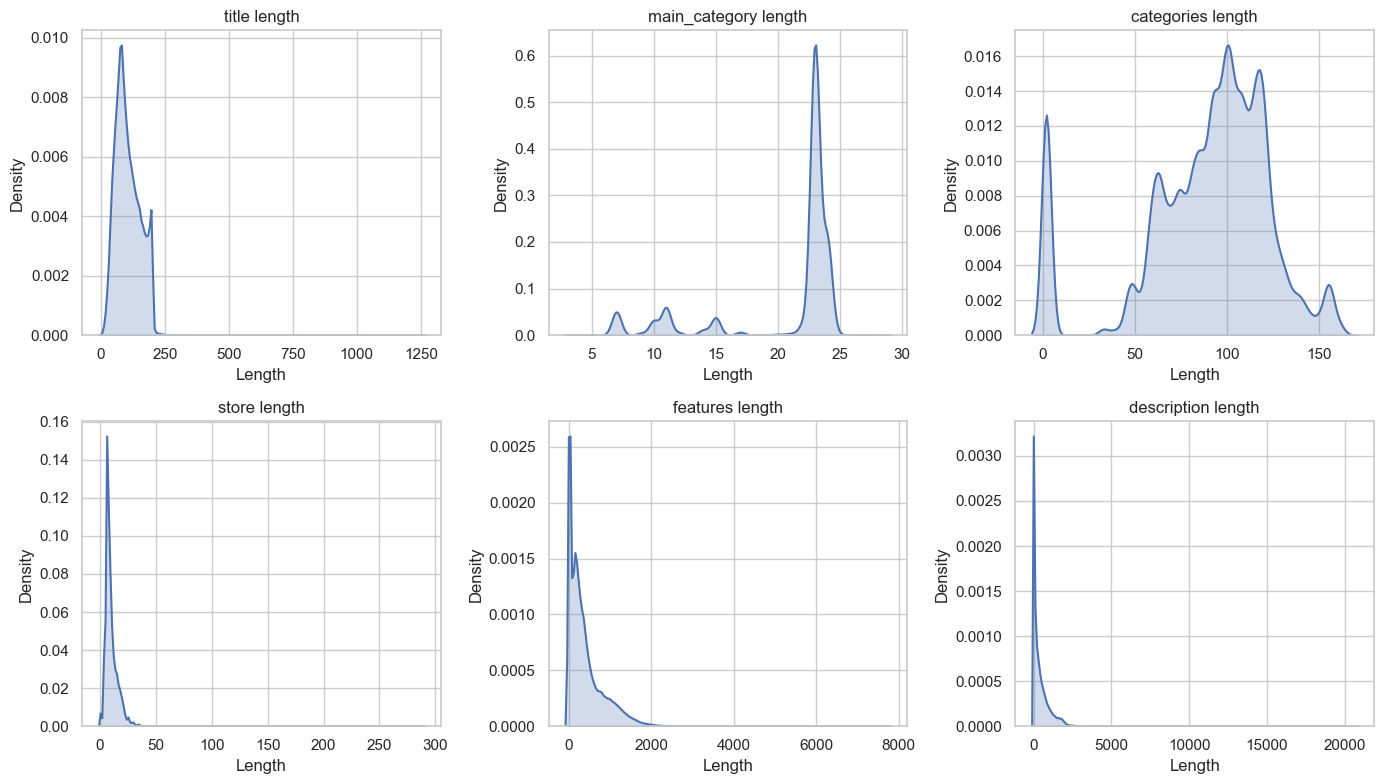

In [5]:
import csv
import seaborn as sns
import matplotlib.pyplot as plt

text_cols = ['title', 'main_category', 'categories', 'store', 'features', 'description']
lengths = {k: [] for k in text_cols}

with open(dst, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        for k in text_cols:
            v = (row.get(k) or '').strip()
            lengths[k].append(len(v))

sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=False, sharey=False)
axes = axes.ravel()

for ax, k in zip(axes, text_cols):
    sns.kdeplot(lengths[k], ax=ax, fill=True, linewidth=1.5)
    ax.set_title(f'{k} length')
    ax.set_xlabel('Length')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


## 结果检查（可选）
运行后可用系统命令查看行数：

```bash
wc -l data/industrial_and_scientific_items_clean.csv
```
